This is part 2 of a course called Full Stack Graph Machine Learning by <a href="https://linkedin.com/in/russelljurney">Russell Jurney</a>. For team training inquiries contact <a href="mailto:rjurney@graphlet.ai">rjurney@graphlet.ai</a>.

In [1]:
import calendar
import json
import os
import pickle
import random
import re
import sys
from datetime import date
from typing import List

import dateutil
import graphistry
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from graphml_class.clean import clean_graph
from graphml_class.palette import CATEGORICAL_PALETTE

sns.set(style='white', context='poster')

Part 2: Network Science: Quantitative Networks
==============================================

Having demonstrated _knowledge graph construction_ in Part 1, it is time to survey network science! Please keep in mind that as a vast and multidisciplinary field with papers covering many areas of science, network science is impossible to cover completely. What I will do is paint the broad strokes of tools common to many fields where network science is used to analyze and understand domain-specific networks.

_Note: you may notice we don't cover community detection [graph clustering] or role discovery in this section of the course. That's because we do so in Part 4 - Graph Machine Learning :)_

## Section Textbook

<center><img src="images/Network-Science-Book-by-Albert-Laszlo-Barabasi.png" width="800px"/></center>

[Network Science](http://networksciencebook.com) is a book on the web at [http://networksciencebook.com/](http://networksciencebook.com/) by Albert-László Barabási is an excellent resource that contains more information than I can cover in 20 classroom hours. It is a resource where you can look up terms and techniques. [Albert-László Barabási](https://barabasi.com/) [see his [Wikipedia page](https://en.wikipedia.org/wiki/Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si)] is a world-renowned expert who discovered [Scale Free Networks](https://en.wikipedia.org/wiki/Scale-free_network). Network Science provides more in-depth treatment of topics like [graph theory](http://networksciencebook.com/chapter/2), [random networks](http://networksciencebook.com/chapter/3) and [communities](http://networksciencebook.com/chapter/9), as well as many more. I encourage students to take the time to review what we cover in this section of the course in Network Science and to refer to it later as well.

## Setting up Graphistry

Throughout this part of the course we will be using `pygraphistry` and [Graphistry Hub](https://hub.graphistry.com/) [https://hub.graphistry.com/](https://hub.graphistry.com/) to visualize networks. Both are free for personal use and are powerful for visualizing networks large and small.

You can [signup](https://hub.graphistry.com/accounts/signup/) for a Graphistry account at [https://hub.graphistry.com/accounts/signup/](https://hub.graphistry.com/accounts/signup/). <b>You should use a username/password/email to get the required credentials</b>, although after that you can login with your Github or Google account.

<center><img src="images/graphistry_hub_registration.png" /></center>

Retain and use your credentials in the login form and in the environment variables in the next cell below. You should set the `GRAPHISTRY_USERNAME` and `GRAPHISTRY_PASSWORD` variables in the `env/graphistry.env` file, and then restart this docker container to pickup the new values.

<center><img src="images/graphistry_hub_homepage.png" /></center>

In [97]:
# Environment variable setup
GRAPHISTRY_USERNAME = os.getenv("GRAPHISTRY_USERNAME")
GRAPHISTRY_PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")
# GRAPHISTRY_SERVER = os.getenv("GRAPHISTRY_SERVER")

In [99]:
# May need to re-run if you step away for a while
graphistry.register(
    api=3,
    username=GRAPHISTRY_USERNAME,
    password=GRAPHISTRY_PASSWORD,
    server="hub.graphistry.com",
)

In [100]:
# Configuration for Graphistry
GRAPHISTRY_PARAMS = {
    "play": 500,
    "pointOpacity": 0.7,
    "edgeOpacity": 0.3,
    "edgeCurvature": 0.3,
    "showArrows": True,
    "gravity": 0.15,
    "showPointsOfInterestLabel": False,
    "labels": {
        "shortenLabels": False,
    },
}
FAVICON_URL = "https://graphlet.ai/assets/icons/favicon.ico"
LOGO = {"url": "https://graphlet.ai/assets/Branding/Graphlet%20AI.svg", "dimensions": {"maxWidth": 100, "maxHeight": 100}}

# Network Science on Citation Networks

We are going to use the knowledge graph (property graph) we prepared in Part 1. Jst as a review, let me remind you what that dataset is...

## High Energy Physics Theory Citation Network (arXiv)

We built a simple, directional `nx.DiGraph` of a citation network where nodes are papers and citations are edges [High-energy physics theory citation network](https://snap.stanford.edu/data/cit-HepTh.html) from [Stanford SNAP](http://snap.stanford.edu/). A citation network describes how one academic paper cites another one.

> Arxiv HEP-TH (high energy physics theory) citation graph is from the e-print arXiv and covers all the citations within a dataset of 27,770 papers with 352,807 edges. If a paper i cites paper j, the graph contains a directed edge from i to j. If a paper cites, or is cited by, a paper outside the dataset, the graph does not contain any information about this.
>
> The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv, and thus represents essentially the complete history of its HEP-TH section.
>
> The data was originally released as a part of [2003 KDD Cup](http://www.cs.cornell.edu/projects/kddcup/).

J. Leskovec, J. Kleinberg and C. Faloutsos. [Graphs over Time: Densification Laws, Shrinking Diameters and Possible Explanations.](http://www.cs.cmu.edu/~jure/pubs/powergrowth-kdd05.pdf) ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2005.

## Dataset Citation

```
Paper: hep-th/0002031
From: Maulik K. Parikh 
Date: Fri, 4 Feb 2000 17:04:51 GMT   (10kb)

Title: Confinement and the AdS/CFT Correspondence
Authors: D. S. Berman and Maulik K. Parikh
Comments: 12 pages, 1 figure, RevTeX
Report-no: SPIN-1999/25, UG-1999/42
Journal-ref: Phys.Lett. B483 (2000) 271-276
\\
  We study the thermodynamics of the confined and unconfined phases of
superconformal Yang-Mills in finite volume and at large N using the AdS/CFT
correspondence. We discuss the necessary conditions for a smooth phase
crossover and obtain an N-dependent curve for the phase boundary.
\\
```

## Tools

We use `networkx`, `pandas` and optionally you may use `cugraph` to re-implement parts of this course section using your GPU. The `rapids` docker image can help.

```bash
docker compose up rapids
```

This runs a Jupyter Notebook that has NVIDIA support enabled. This *should* work by the time you read this :)

### About NetworkX

The [networkx Algorithms documentation](https://networkx.org/documentation/stable/reference/algorithms/index.html) lists a fairly comprehensive set of tools available for the network scientist. We will be using networkx throughout the course.

### About cuGraph

The [NVIDIA RAPIDS cuGraph](https://docs.rapids.ai/api/cugraph/stable/) ([Github](https://github.com/rapidsai/cugraph)) is a GPU accelerated graph analytics library that is roughly compatible with `networkx`. It can rapidly compute expensive metrics compare to CPU, where processing is often limited to a single core. An NVIDIA GPU and cuGraph are optional in this course, but will be helpful as you use complex algorithms on large networks.

## Load and Test our Citation Graph

Load the data and count the nodes and edges.

In [5]:
G: nx.DiGraph = nx.read_gexf(path="data/physics_labeled.gexf.gz")

In [6]:
G.number_of_nodes(), G.number_of_edges()

(27770, 352807)

## Load the File to Net and Net to File Node ID Mappings

We use these below, so we [pickled](https://wiki.python.org/moin/UsingPickle) them in Part 1. JSON can't handle numeric keys, or we would have used that :)

In [7]:
with open("data/citation/file_to_net.pkl", "rb") as f:
    file_to_net = pickle.load(f)

# Everything ok? Yes!
list(file_to_net.items())[0:10]

[(1001, 0),
 (9304045, 1),
 (9308122, 2),
 (9309097, 3),
 (9311042, 4),
 (9401139, 5),
 (9404151, 6),
 (9407087, 7),
 (9408099, 8),
 (9501030, 9)]

In [8]:
with open("data/citation/net_to_file.pkl", "rb") as f:
    net_to_file = pickle.load(f)

# Everything ok here too? Yes!
list(net_to_file.items())[0:10]

[(0, 1001),
 (1, 9304045),
 (2, 9308122),
 (3, 9309097),
 (4, 9311042),
 (5, 9401139),
 (6, 9404151),
 (7, 9407087),
 (8, 9408099),
 (9, 9501030)]

## Convert our `str` Node / Edge IDs to `int` IDs

We lost something when we saved in GEXF format and loaded the graph back. All our node and edge IDs are strings... we must convert them back to integers before we move on, as some libraries require this!

In [9]:
def convert_ids_to_int(G):
    # Create a new directed graph
    G_int = nx.DiGraph()
    
    # Create a mapping from string IDs to integer IDs
    id_mapping = {str_id: int(str_id) for str_id in G.nodes()}
    
    # Copy nodes and attributes, converting IDs to integers
    for str_id, data in G.nodes(data=True):
        int_id = id_mapping[str_id]
        G_int.add_node(int_id, **data)
    
    # Copy edges and attributes, converting IDs to integers
    for str_id1, str_id2, data in G.edges(data=True):
        int_id1, int_id2 = id_mapping[str_id1], id_mapping[str_id2]
        G_int.add_edge(int_id1, int_id2, **data)
    
    return G_int

# Convert G to use integer IDs
G_int = convert_ids_to_int(G)

In [10]:
G_int.number_of_nodes(), G_int.number_of_edges()

(27770, 352807)

In [11]:
# Let's test or integer index now... we pickled it instead of JSONized it so it would retain its integer keys and values!
test_id = file_to_net[9711194]
G_int.nodes[test_id]

{'file_id': 9711194,
 'sequential_id': 5886,
 'Paper': 'hep-th/9711194',
 'Date': 'Wed, 26 Nov 1997 20:26:20 GMT',
 'Title': 'On Integrable Structure behind the Generalized WDVV Equations',
 'Comments': 'LaTeX, 6pp',
 'Report-no': 'ITEP/TH-67/97',
 'Journal-ref': 'Phys.Lett. B427 (1998) 93-96',
 'Abstract': 'In the theory of quantum cohomologies the WDVV equations imply integrability of the system $(I\\partial_\\mu - zC_\\mu)\\psi = 0$. However, in generic situation -- of which an example is provided by the Seiberg-Witten theory -- there is no distinguished direction (like $t^0$) in the moduli space, and such equations for $\\psi$ appear inconsistent. Instead they are substituted by $(C_\\mu\\partial_\\nu - C_\\nu\\partial_\\mu)\\psi^{(\\mu)} \\sim (F_\\mu\\partial_\\nu - F_\\nu\\partial_\\mu)\\psi^{(\\mu)} = 0$, where matrices $(F_\\mu)_{\\alpha\\beta} = \\partial_\\alpha \\partial_\\beta \\partial_\\mu F$.',
 'Journal-ref-DBSCAN': 2,
 'Journal-ref-Label': 'Phys.Lett.',
 'label': '588

### `G_int` --> `G`

Now we can assign our new integer graph back to `G` and use it below :)

In [12]:
G = G_int

## Summarize the Properties of our DiGraph

Let's check how many nodes and edges we have. This will help evaluate how we are doing when we parse the abstracts to add properties to our DiGraph.

In [13]:
print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Total edges: {G.number_of_edges():,}")
print(f"Total components: {nx.number_connected_components(G.to_undirected()):,}")
print(f"Undirected is weakly connected: {nx.is_weakly_connected(G)}")

Total nodes: 27,770
Total edges: 352,807
Total components: 143
Undirected is weakly connected: False


### Describe a NetworkX Graph

In [14]:
def describe_graph(G):
    """Given a networkx Graph, describe its key properties."""

    print(f"Number of nodes: {G.number_of_nodes():,}")
    print(f"Number of edges: {G.number_of_edges():,}")

    # Compute various network properties
    degrees = [deg for node, deg in nx.degree(G)]
    avg_degree = sum(degrees) / G.number_of_nodes()
    median_degree = np.median(degrees)
    print(f"Mean degree: {avg_degree:,.3f}")
    print(f"Mediam degree: {median_degree:,.3f}")

    components = nx.connected_components(G.to_undirected())
    largest_component = max(components, key=len)
    print(f"Number of connected components: {nx.number_connected_components(G.to_undirected()):,}")
    print(f"Size of the largest component: {len(largest_component):,}")

    # If the network is directed, you can also print the following
    if G.is_directed():
        print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G):,}")
        print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G):,}")

    avg_clustering = nx.average_clustering(G)
    median_clustering = np.median(list(nx.clustering(G).values()))
    print(f"Mean clustering coefficient: {avg_clustering:.6f}")
    print(f"Median clustering coefficient: {median_clustering:.6f}")

    # try:
    #     avg_shortest_path_length = nx.average_shortest_path_length(G)
    #     print(f"Average shortest path length: {avg_shortest_path_length}")
    # except nx.NetworkXError:
    #     print("Graph is not connected, average shortest path length is not defined.")

describe_graph(G)

Number of nodes: 27,770
Number of edges: 352,807
Mean degree: 25.409
Mediam degree: 14.000
Number of connected components: 143
Size of the largest component: 27,400
Number of strongly connected components: 20,086
Number of weakly connected components: 143
Mean clustering coefficient: 0.156925
Median clustering coefficient: 0.143275


### Histogram of Connected Component Sizes

143 weakly connected components - our graph is not one large hairball! Let's see what sizes our connected components are. Usually these are a power law distribution, with one large component taking up 30 or more percent of nodes and edges.

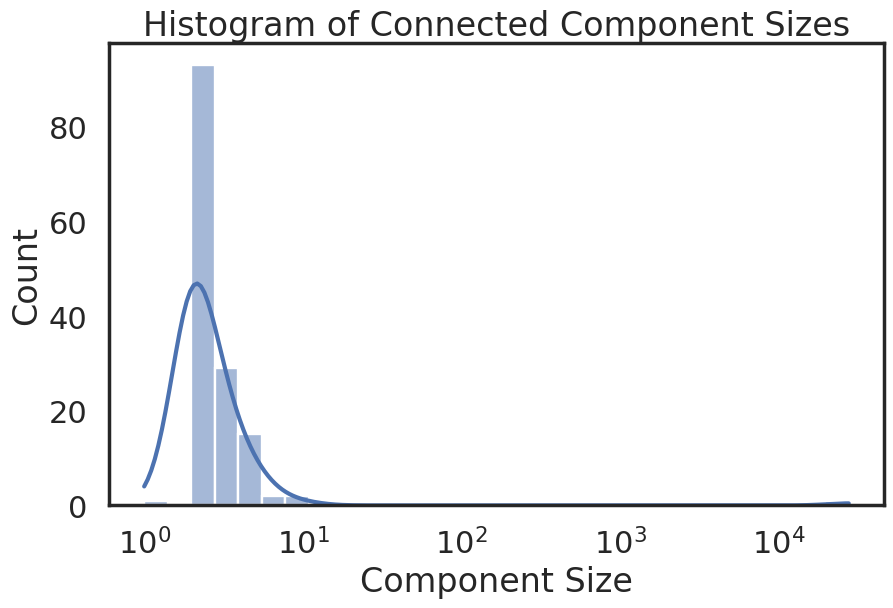

In [15]:
# Get connected components and their sizes
components = nx.connected_components(G.to_undirected())
component_sizes = [len(c) for c in components]

# Increase figure size
plt.figure(figsize=(10,6))

# Use seaborn to create the histogram
sns.histplot(component_sizes, kde=True, bins=30, log_scale=True)
plt.title('Histogram of Connected Component Sizes')
plt.xlabel('Component Size')
plt.ylabel('Count')
plt.show()

In [16]:
nx.connected_components(G.to_undirected())

<generator object connected_components at 0x7fff39f66c40>

## Average Clustering Coefficient

The clustering coefficient is an indicator of the interconnectedness or cohesion among nodes in a graph. It's a measure of the extent to which the immediate neighbors of a particular node link to each other.

The range of a clustering coefficient is between 0 and 1:

When the clustering coefficient is 0, it signifies a scenario where none of the nodes have direct connections with each other. This can be seen in graphs such as a tree or a radial network where nodes are only connected to a central hub, but not with each other.

In contrast, a clustering coefficient of 1 indicates a fully connected graph. Here, each node in the graph is directly linked with all other nodes.

In [17]:
# A good start...
print(f"Mean degree: {G.number_of_edges()/G.number_of_nodes():.3f}")
print(f"Median degree: {np.median([deg for node, deg in G.degree()]):.3f}")

clustering_coefficient = nx.average_clustering(G)
print(f"Graph clustering coefficient: {clustering_coefficient:.3f}")
print(f"Median clustering coefficient: {np.median([coeff for node, coeff in nx.clustering(G).items()]):.3f}")

Mean degree: 12.705
Median degree: 14.000
Graph clustering coefficient: 0.157
Median clustering coefficient: 0.143


An average clustering coefficient of 0.16 in our `nx.DiGraph` implies there is a relatively low degree of clustering or tight-knit communities. It suggests a network structure that is more spread out, with fewer connections among immediate neighbors of each node. Networks such as web pages or citation networks often present lower clustering coefficients, as these networks are characterized by a wide range of diverse connections that do not necessarily link back to each other. Citation networks are actually temporal networks and are constrained by the fact that papers can't cite future papers, but only past ones. They are therefore DAGs - directed, acyclic graphs.

### Node Clustering Coefficients

The clustering coefficient of a node is a measure of the degree to which nodes in a graph tend to cluster together. It provides an indication of how the neighbors of a _particular node_ are interconnected. It measures how close a node's neighbors are to being a complete graph or a clique. It is defined as the fraction of possible triangles that exist through the node, or equivalently, as the fraction of the node's neighbors that are also neighbors of each other.

We're going to add a property to each node in the network for each node's clustering coefficient. You can find more on clustering coefficients in citation networks in [Modeling the clustering in citation networks](https://arxiv.org/abs/1104.4209).

In [18]:
clustering_coeffs = nx.clustering(G)

for node, clustering_coeff in clustering_coeffs.items():
    G.nodes[node]['clustering_coefficient'] = clustering_coeff

Let's look at how the clustering coefficient is distributed.

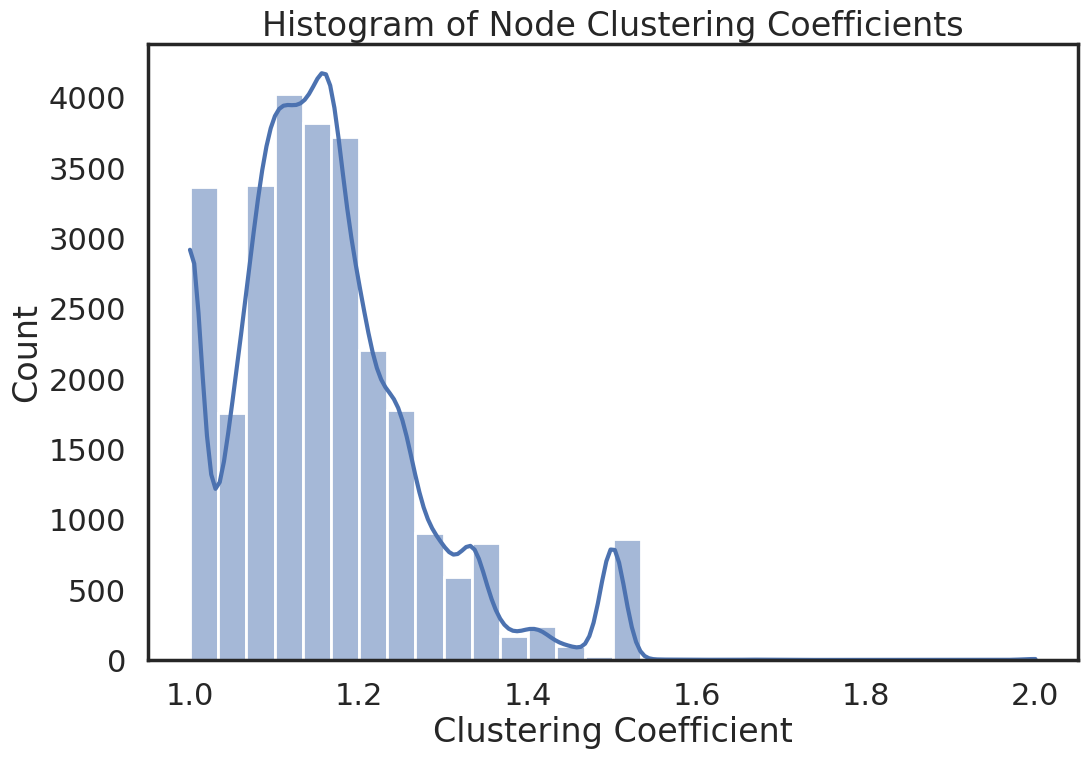

In [19]:
# Get connected components and their sizes
clustering_coeff_counts = [val + 1 for key, val in clustering_coeffs.items()]

plt.figure(figsize=(12,8))

# Use seaborn to create the histogram
sns.histplot(clustering_coeff_counts, kde=True, bins=30, log_scale=False)
plt.title('Histogram of Node Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Count')
plt.show()

A clustering coefficient of around 0.2 indicates that most nodes have relatively low (but still significant) clustering coefficients - their neighbors are sparsely connected. How does this fit with the average degree of 12 and graph clustering coefficient of 0.16? 16% of the average node's connections are connected with one another. From the histogram which has a skewed but fairly normal distribution, it looks like the _typical_ node has these properties as well. These are characteristics of a [Small World Network](https://en.wikipedia.org/wiki/Small-world_network). Most citation graphs are [small world networks](https://en.wikipedia.org/wiki/Citation_graph). 

Note: NetworkX has a set of functions [`networkx.algorithms.smallworld`](https://networkx.org/documentation/stable/reference/algorithms/smallworld.html) that can determine the "small worldiness of a network."

Why do we care what kind of theoretical graph model fits our *real world* network. Because the field of network science is multidisciplinary and papers cover topics from physics to biology to sociology to microchip design. The type of network you have - often in the same settings as yours - has been rigorously studied. Reading a paper or two describing your graph gives you the context you need to extract insights, build models and auomate tasks using machine learning and artificial intelligence.

# Visualizing Networks in Graphistry

[Graphistry](https://graphistry.com/) can handle hundreds of thousands of nodes and edges using GPU acceleration. They provide GPU acceleration via [Graphistry Hub](https://hub.graphistry.com/), so we don't need to have a GPU in our notebook computers. That being said... we will sample our network to our algorithms below run faster and avoid any problems on slower computers.

Once we sample, let's take a first look at our network in Graphistry to see what it looks like! First we are going to use a sampling hack, and then we are going to use [littleballoffur](https://github.com/benedekrozemberczki/littleballoffur) to sample _properly_ (or at least how we expect!) in a variety of ways.

## Node Sampling Hack: PageRank Weighted Random Nodes

The entire network of millions of nodes is too large for Graphistry. We will sample it down to about 15% of its original size and take a peek :)

> The most obvious way to create a sample graph is to uniformly at random select a set of nodes N and a sample is then a graph induced by the set of nodes N. We call this algorithm the Random Node (RN) sampling.

--Leskovec and Faloutsos, 2006

We are going to randomly sample nodes to get a set of nodes, and then connect them with all incident edges, the induced subgraph of the sample nodes. Rather than sample uniformly, we will weight with nodes' probabilities by their normalized degrees and PageRank scores. This technique was suggested by [Jure Leskovec](https://dblp.org/pid/l/JureLeskovec.html) and [Christos Faloutsos](https://dblp.org/pid/f/CFaloutsos.html) in the paper [Sampling from Large Graphs](https://cs.stanford.edu/~jure/pubs/sampling-kdd06.pdf) which presents a range of techniques for sampling large graphs.

One thing from this paper to note, is the minimum sample size to maintain a network's structural properties.

> We show that a 15% sample is usually enough, to match the properties (S1–S9 and T1–T5) of the real graph.

In [20]:
# Degree-based probabilities
degrees = [degree for (node_id, degree) in G.degree()]
degree_probs = np.array(degrees) / np.sum(degrees)
degree_probs, degree_probs.shape

(array([1.31800106e-04, 2.40924925e-05, 1.72899064e-04, ...,
        8.50323265e-06, 1.41720544e-06, 1.13376435e-05]),
 (27770,))

In [21]:
# PageRank-based probabilities
pagerank_probs = np.array(list(nx.pagerank(G).values()))
pagerank_probs, pagerank_probs.shape

(array([1.34055257e-05, 6.14831316e-05, 2.55518652e-04, ...,
        1.08840246e-05, 1.08840246e-05, 1.08840246e-05]),
 (27770,))

In [22]:
# Degree node ID sample
degree_node_sample = np.random.choice(G.nodes(), size=5000, replace=False, p=degree_probs)
degree_node_sample, degree_node_sample.shape

(array([17275,   811, 20257, ...,  3345, 16542,  5883]), (5000,))

In [23]:
# Degree sampled subgraph
G_degree_sample = G.subgraph(degree_node_sample).copy()
G_degree_sample.number_of_nodes(), G_degree_sample.number_of_edges()

(5000, 61577)

In [24]:
# PageRank node ID sample
pagerank_node_sample = np.random.choice(G.nodes(), size=5000, replace=False, p=pagerank_probs)
pagerank_node_sample, pagerank_node_sample.shape

(array([12459,  4428,  7700, ...,  1515, 26939, 16774]), (5000,))

In [25]:
# PageRank sampled subgraph
G_pagerank_sample = G.subgraph(pagerank_node_sample).copy()
G_pagerank_sample.number_of_nodes(), G_pagerank_sample.number_of_edges()

(5000, 35294)

### Interpreting Sample Node / Edge Counts

Note that while both degree and pagerank weighted random graph samples have 5,000 nodes the degree weighted sample has 65,000 edges and the PageRank weighted sample has just 34,000. That means the degree weighted sample is more biased towards hubs - high degree nodes.

### Remove all Degree 0 Nodes from Both Subgraphs

They hover around the outer edge and don't encode much information.

Look at the node and edge counts. Note how there are more edges in the degree-weighted sample than the PageRank weighted sample. This is how Leskovec describes it - as being biased towards nodes with a higher degree.

In [26]:
# Remove degree sampled zero-degree ndoes
degree_degree_gt_zero = [node for node, degree in G_degree_sample.degree() if degree > 0]
G_degree_gt_zero = G_degree_sample.subgraph(degree_degree_gt_zero).copy()

G_degree_gt_zero.number_of_nodes(), G_degree_gt_zero.number_of_edges()

(4835, 61577)

In [27]:
# Remove PageRank sample zero-degree nodes
pagerank_degree_gt_zero = [node for node, degree in G_pagerank_sample.degree() if degree > 0]
G_pagerank_gt_zero = G_pagerank_sample.subgraph(pagerank_degree_gt_zero).copy()

G_pagerank_gt_zero.number_of_nodes(), G_pagerank_gt_zero.number_of_edges()

(4531, 35294)

## Comparing Degree and PageRank Weighted Sample Visualizations

### Degree Weighted Random Sample

In [28]:
g = (
    graphistry.bind(
        source="src",
        destination="dst",
        node="nodeid",
        point_title="Title",
        point_label="Title",
    )
    .scene_settings(
        edge_opacity=0.4,
    )
    .addStyle(
        page={
            "title": "Degree Weighted Sample",
            "favicon": FAVICON_URL,
        },
        logo=LOGO,
    )
    .settings(
        url_params=GRAPHISTRY_PARAMS,
        height=800,
    )
)
g.plot(G_degree_gt_zero)

<center><img src="images/Graphistry_Figure_1.png" /></center>

### PageRank Weighted Sample

In [29]:
g = (
    graphistry.bind(
        source="src",
        destination="dst",
        node="nodeid",
        point_title="Title",
        point_label="Title",
    )
    .scene_settings(
        edge_opacity=0.4,
    )
    .addStyle(
        page={
            "title": "Degree Weighted Sample",
            "favicon": FAVICON_URL,
        },
        logo=LOGO,
    )
    .settings(
        url_params=GRAPHISTRY_PARAMS,
        height=800,
    )
)
g.plot(G_pagerank_gt_zero)

<center>
<img src="images/Graphistry_Pagerank_Sample.png" />
</center>

### More Sampling Below

We aren't done yet, further down we use the PyPi module `littleballoffur` to try different sampling algorithms!

# IMPORTANT: Select Which Sample to Use

Set the `G` variable to whichever sample you would like to use below. You can comment these lines out to run the metrics on the entire graph.

In [30]:
# To preserve the original graph if we assign a sample to G
G_orig = G.copy()

# If things are slow in the following sections, run this line
# G = G_pagerank_gt_zero.copy()
# G = G_degree_gt_zero.copy()

# Back to the original
# G = G_orig

# Describing our Citation Network `nx.DiGraph`

Now we can check a few theoretical properties of our DiGraph. I'll frame it in terms of questions and metrics.

* Domain question: How many citations does each paper have across the entire network?
* Metric 1: What is the average degree, in-degree and out-degree of the network?

In [31]:
# Extract degree, in-degree, and out-degree for each node
# +1 is to avoid problems with log-scale display
degree_sequence = [d + 1 for n, d in G.degree()]
in_degree_sequence = [d + 1 for n, d in G.in_degree()]
out_degree_sequence = [d + 1 for n, d in G.out_degree()]

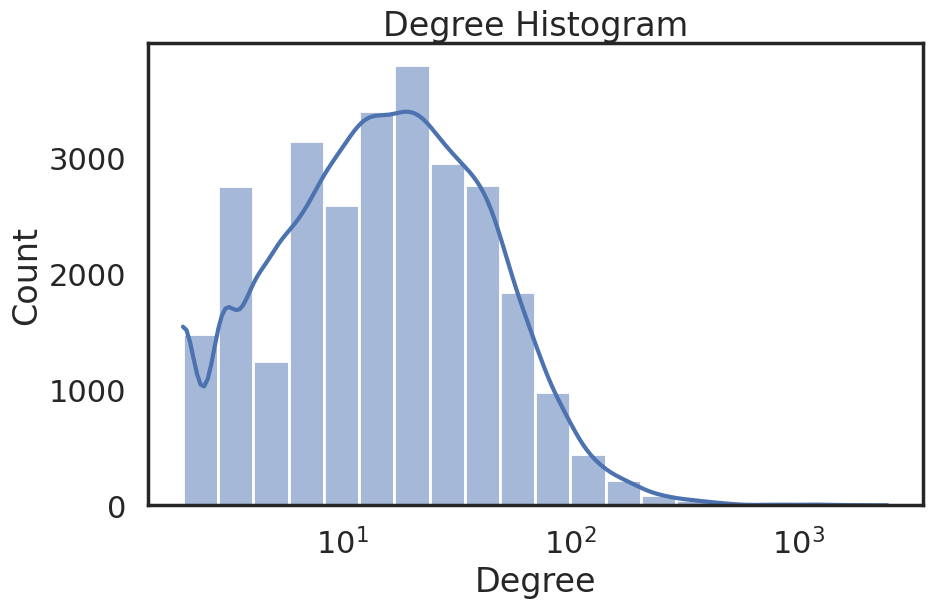

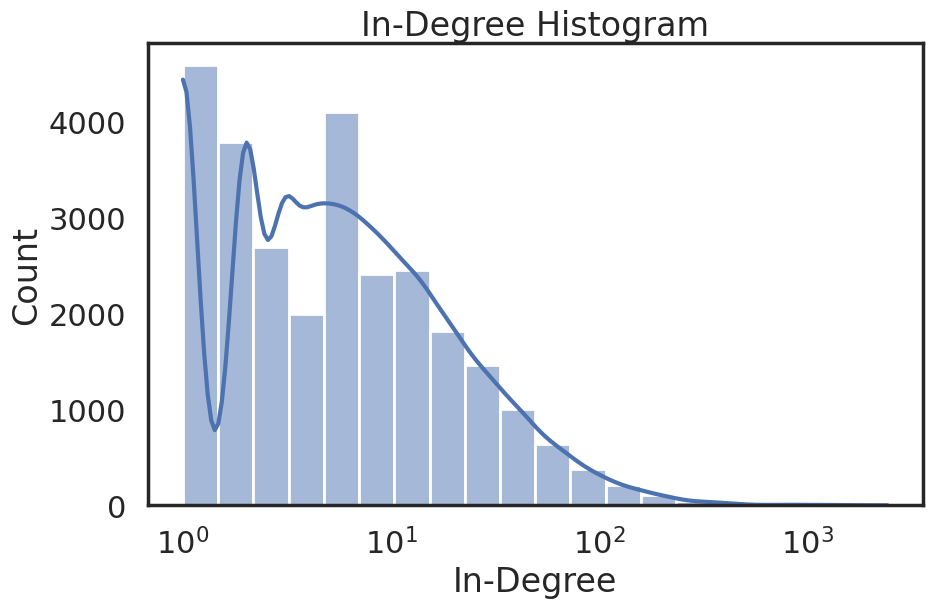

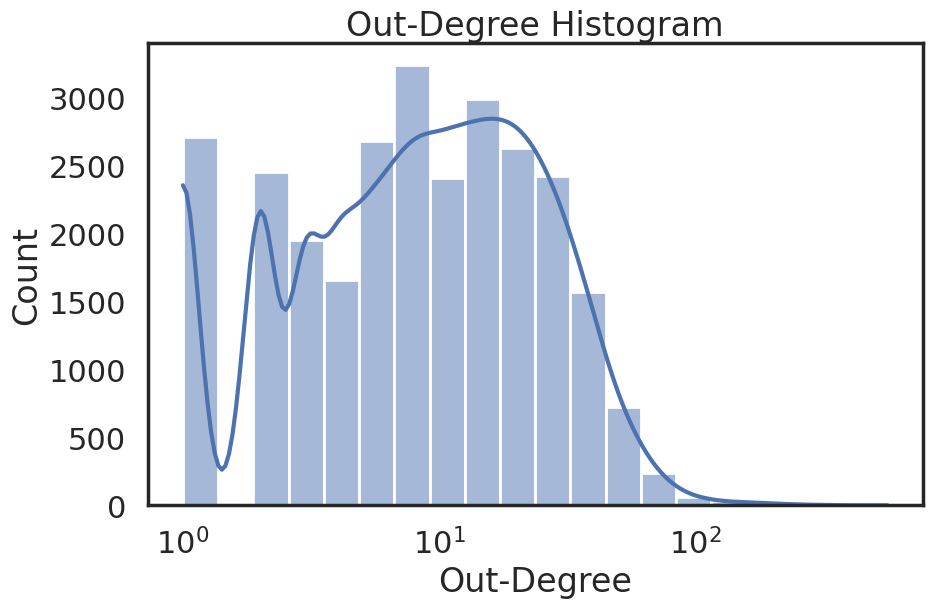

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(10,6))

# Create histogram of degree
ax = sns.histplot(degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='Degree')
plt.title('Degree Histogram')
plt.show()

# Increase figure size
plt.figure(figsize=(10,6))

# Create histogram of in-degree
ax = sns.histplot(in_degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='In-Degree')
plt.title('In-Degree Histogram')
plt.show()

# Increase figure size
plt.figure(figsize=(10,6))

# Create histogram of out-degree
ax = sns.histplot(out_degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='Out-Degree')
plt.title('Out-Degree Histogram')
plt.show()

## Tactical Decision: Removing Uncited Papers

Uncited papers aren't very interesting - they have degree of zero - so aren't part of any connected component of a network. Let's filter them.

In [33]:
print(f"Nodes before removal: {G.number_of_nodes():,}")

# Remove the isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Nodes after removal: {G.number_of_nodes():,}")

Nodes before removal: 27,770
Nodes after removal: 27,770


# Bridges

If removing an edge between two nodes breaks a single component into multiple components, that edge was a bridge. Let's check if our network has any bridges.

In [34]:
nx.has_bridges(G.to_undirected())

True

## Examining Bridges in Graphistry

Let's examine bridges and local bridges in Graphistry by adding them as node properties to our network.

In [35]:
bridge_edges = nx.bridges(G.to_undirected())
# nx.set_edge_attributes(G, bridge_edges, "bridge")

In [36]:
list(G.edges(data=True))[:10]

[(0, 1, {'edge_id': 4, 'id': '0'}),
 (0, 2, {'edge_id': 5, 'id': '1'}),
 (0, 3, {'edge_id': 6, 'id': '2'}),
 (0, 4, {'edge_id': 7, 'id': '3'}),
 (0, 5, {'edge_id': 8, 'id': '4'}),
 (0, 6, {'edge_id': 9, 'id': '5'}),
 (0, 7, {'edge_id': 10, 'id': '6'}),
 (0, 8, {'edge_id': 11, 'id': '7'}),
 (0, 9, {'edge_id': 12, 'id': '8'}),
 (0, 10, {'edge_id': 13, 'id': '9'})]

## Assortativity

[Assortativity](https://en.wikipedia.org/wiki/Assortativity) in networks refers to a correlation pattern observed in real-world networks where nodes are preferentially connected to other nodes that are like (or unlike) them in some way. This is essentially a bias in connection preference.

A related term is _assortative mixing_:

> In the study of complex networks, assortative mixing, or assortativity, is a bias in favor of connections between network nodes with similar characteristics. In the specific case of social networks, assortative mixing is also known as homophily. The rarer disassortative mixing is a bias in favor of connections between dissimilar nodes.

--Wikipedia, [Assortative Mixing](https://en.wikipedia.org/wiki/Assortative_mixing)

This can be summarized via the assortativity coefficient.

> The assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes.

--Wikipedia, [Assortativity](https://en.wikipedia.org/wiki/Assortativity)

Pearson's is the covariance of two distributions divided by the product of their standard deviations. Assortativity adapts it for pairs of nodes while accounting for the degree of each node.

<center><img src="images/pearsons_equation_no_cov.png" width="500px" alt="Equation for Pearson's Correlation Coefficient" /></center>

### Computing Degree Assortativity

One type of assortativity is _degree assortativity_, which measures to what extent nodes connect to other nodes with similar degrees.

It ranges from -1 to 1. We will use the NetworkX API [nx.algorithms.assortativity.degree_assortativity_coefficient](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient) to compute it.

In [37]:
degree_assort = nx.degree_assortativity_coefficient(G)
degree_assort

0.0017156007411713394

The value for degree assortativity we computed above of 0.00172 indicates that overall nodes often associate with similar or dissimilar nodes by degree in roughly equal proportions. There is no correlation between the degree of nodes and their tendency to connect.

In a citation network, a higher assortativity can mean that papers with many citations (high degree nodes) tend to cite other papers with many citations. This could reflect a phenomenon where "popular" or foundational papers are often cited together. A lower assortativity might suggest that highly-cited papers are citing less-cited papers, indicating a wider __dispersion__ of references and potentially more novel research that builds on less well-known work.

### In-Degree Assortativity

Let's check how often papers connect to similar papers according to how many in-bound citations they have.

In [38]:
nx.degree_assortativity_coefficient(G, x="in", y="in")

0.04052647611784706

You can see there is a higher positive correlation, but only around 0.1, indicating papers display a small amount assortative mixing with respect to the number of citations they receive.

### Out-Degree Assortativity

And... how often do papers that cite many papers cite papers that themselves cite many papers? Conversely, how often do papers that cite only a few papers cite other papers that cite only a few papers? If out-degree assortativity is high, it might be interesting to incorporate this last question into a connected components analysis, since there might be interesting components of low citation papers all on their own, encoding their own areas of science :)

In [39]:
nx.degree_assortativity_coefficient(G, x="out", y="out")

0.09560498803242364

More of the same. Let's try answering the following questions:

1) Is there assortative mixing between papers that are often cited and papers that themselves cite many papers?
2) Is there assortative mixing between papers that cite many papers and papers that are often cited?

In [40]:
# 1) x="in" [cited a lot], x="out" [cite a lot]
print(f'In / Out Degree Assortativity Coefficient: {nx.degree_assortativity_coefficient(G, x="in", y="out"):,.3f}')

# 2) x="out" [cite a lot], x="in" [cited a lot]
print(f'Out / In Degree Assortativity Coefficient: {nx.degree_assortativity_coefficient(G, x="out", y="in"):,.3f}')

In / Out Degree Assortativity Coefficient: 0.006
Out / In Degree Assortativity Coefficient: 0.002


Ok, we give up! While I hope you understand this tool, it isn't very illuminating here :)

## Dispersion

In interpreting our degree assortativity, we mentioned _dispersion_, another network metric that indicates how well the neighbors of two nodes are connected to one another. Recall that _clustering coefficient_ indicates how well the neighbors of two nodes are _directly connected_. Dispersion is a similar measure that includes paths with lengths longer than 1.

Let's consider a simple example with nodes A and B. Suppose A and B have a set of mutual contacts or neighbors. If these mutual contacts are also connected to each other, forming a tightly-knit community, the dispersion is low. However, if these mutual contacts aren't connected to each other, the dispersion is high.

In a social network setting, a high dispersion between two individuals might mean that they connect different parts of a network, which can be an indication of a close or important relationship. For example, in a group of friends, a romantic couple might have a high dispersion because each person connects the other to a different social group, and their mutual friends don't necessarily know each other.

Below we use the [nx.algorithms.centrality.dispersion](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.dispersion.html) to compute the mean dispersion between the paper [M Theory As A Matrix Model: A Conjecture, Banks et al, 1997](https://arxiv.org/abs/hep-th/9610043) and its 1,219 citation edges.

In [41]:
mean_dispersion = np.mean(list(nx.dispersion(G, file_to_net[9610043]).values()))
print(f"Mean Dispersion: {mean_dispersion:,.3f}")

median_dispersion = np.median(list(nx.dispersion(G, file_to_net[9610043]).values()))
print(f"Median Dispersion: {median_dispersion:,.3f}")

Mean Dispersion: 0.562
Median Dispersion: 0.500


In [42]:
# I crash notebook
# shortest_path_lengths = list(nx.shortest_path_length(G))
# shortest_path_lengths

### Interpreting Dispersion = Hard

Dispersion scores are relative to an individual network's context. We can't interpret the mean and median dispersion scores without putting them into the contxt of the other nodes' dispersions. Let's get the maximium dispersion and plot a histogram of mean dispersions.

In [43]:
dispersions = nx.dispersion(G)
# dispersions

In [44]:
# Process the outer dict for each node and its inner dict for all other nodes
long_list_of_dispersions = np.concatenate([
    list(inner_dict.values()) for inner_dict in dispersions.values()
])
long_list_of_dispersions, long_list_of_dispersions.shape

(array([0.        , 0.        , 0.        , ..., 0.75      , 0.66666667,
        0.8       ]),
 (352807,))

In [45]:
# Get the maximum dispersion using a nested list comprehension
max_dispersion = np.max(
    long_list_of_dispersions
)

print(f"Maximum Dispersion: {max_dispersion:,.3f}")

Maximum Dispersion: 24.888


In [46]:
mean_dispersions_per_node = np.array([np.mean(list(dispersion_dict.values())) for dispersion_dict in dispersions.values()])
mean_dispersions_per_node, mean_dispersions_per_node.shape

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(array([1.25655899, 0.        , 0.        , ..., 0.08333333, 0.        ,
        0.42291667]),
 (27770,))

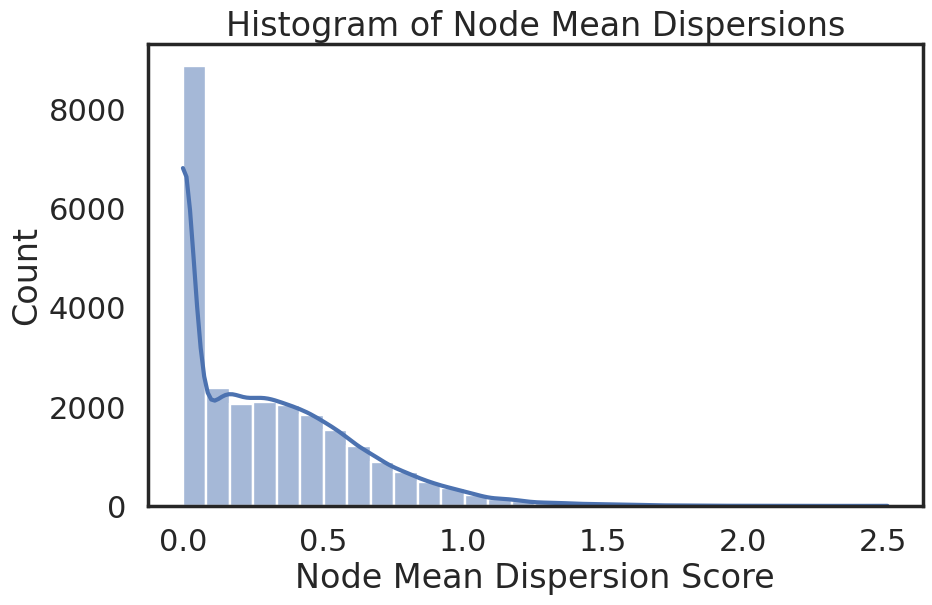

In [47]:
# Increase figure size
plt.figure(figsize=(10,6))

# Use seaborn to create the histogram
sns.histplot(mean_dispersions_per_node, kde=True, bins=30, log_scale=False)
plt.title('Histogram of Node Mean Dispersions')
plt.xlabel('Node Mean Dispersion Score')
plt.ylabel('Count')
plt.show()

### Let's try that in log scale...

In [48]:
# Filter out dispersion scores of 0
logable_mean_dispersions = [x + 0.01 for x in mean_dispersions_per_node if x > 0]

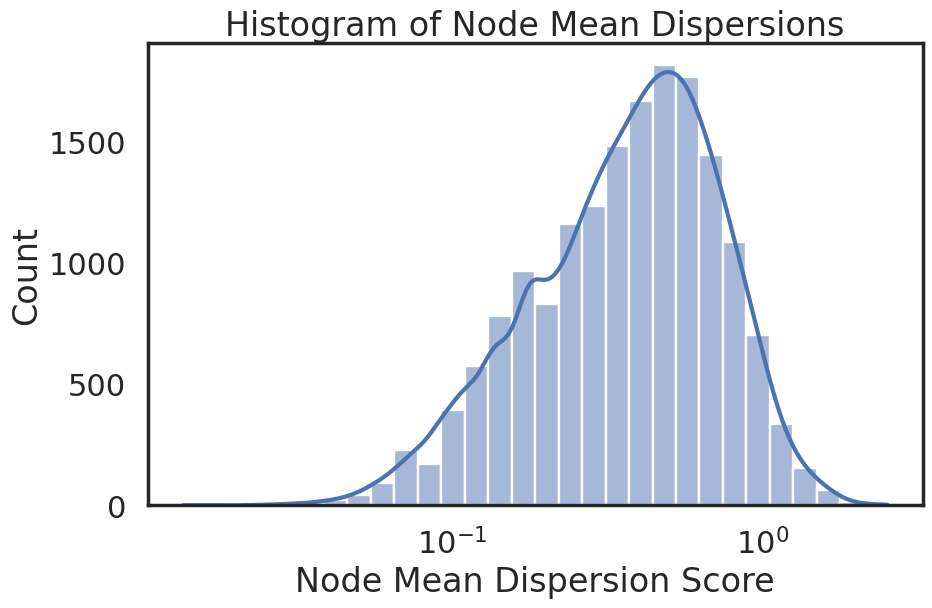

In [49]:
# Increase figure size
plt.figure(figsize=(10,6))

# Use seaborn to create the histogram
sns.histplot(logable_mean_dispersions, kde=True, bins=30, log_scale=True)
plt.title('Histogram of Node Mean Dispersions')
plt.xlabel('Node Mean Dispersion Score')
plt.ylabel('Count')
plt.show()

### Interpreting Node Mean Dispersions

Nodes and their connections have a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) of dispersion scores. For nodes that are connected, most dispersion scores range from 0.1 to 1.

While this provides some additional detail, it isn't that enlightening in this case. We could drill-down to papers with a very high dispersion score to find network bridges, but this is left as an exercise to the student. In a citation graph a network bridge might link on area of science to another, something that few other papers manage.

# Fitting a Random Graph Model to our Network

These degree histograms don't exist in a vacuum. They can be compared to theoretical models of networks to help interpret them. We mean to learn about our network, not simply compute metrics.

NetworkX has many random graph models in the form of [Graph Generators](https://networkx.org/documentation/stable/reference/generators.html) that can generate instances of a random graph. For small graphs, it is neccessary to iteratively generate and measure multiple instances of random graphs. For larger graphs a single instance can work. This is due to the 

## Erdös Reyni Graphs

We begin with a random graph model often used as a baseline, not because it fits real-world networks.

An Erdős–Rényi (ER) graph is a simple model of a random graph. This model is named after Paul Erdős and Alfréd Rényi, who first introduced one version of it.

In the ER model, a graph is constructed by connecting nodes randomly. Each edge is included in the graph with probability p, independent of the other edges. Thus, the model has two parameters: the number of nodes n, and the edge probability p.

The ER model can be used to generate either a G(n, M) graph or a G(n, p) graph.

In the G(n, M) model, a graph is chosen uniformly at random from the collection of all graphs with n nodes and M edges.
In the G(n, p) model, a graph is constructed by connecting nodes randomly where each possible edge occurs independently with probability p.
The ER model is a simple model that does not capture many of the properties of real-world networks, such as their community structure and degree distribution.

However, it is useful in network theory because of its analytical tractability and because it serves as a null model against which the properties of real-world networks can be compared.

In [50]:
# Calculate the edge probability parameter for the Erdos-Renyi model
p = nx.density(G)
print(f"Citation network density: {p:.5f}")

# Create an Erdos-Renyi graph with the same number of nodes and the calculated edge probability
G_er = nx.erdos_renyi_graph(G.number_of_nodes(), p)

Citation network density: 0.00046


In [51]:
def plot_degrees(G, G_compare=None, compare_label=None):
    """Compute the degrees of a graph and compare them to a random graph model."""

    # Increase figure size
    plt.figure(figsize=(10,6))
    
    # Create histogram of degrees in real citation graph
    degree_sequence = [d + .01 for n, d in G.degree()]
    ax = sns.histplot(degree_sequence, bins=20, kde=True, log_scale=True, label="Citation Graph")
    ax.set(xlabel='Degree')

    # Increase figure size
    plt.figure(figsize=(10,6))

    if G_compare:
        # Create histogram of degree and plot alongside
        compare_degree_sequence = [d + 1 for n, d in G_compare.degree()]
        ax = sns.histplot(compare_degree_sequence, bins=20, kde=True, log_scale=True, label=compare_label if compare_label else "Random Graph Model")
        ax.set(xlabel='Degree')
    
        plt.title(f"Degree Histogram Comparison")
    else:
        plt.title("Degree Histogram")

    plt.legend()
    plt.show()

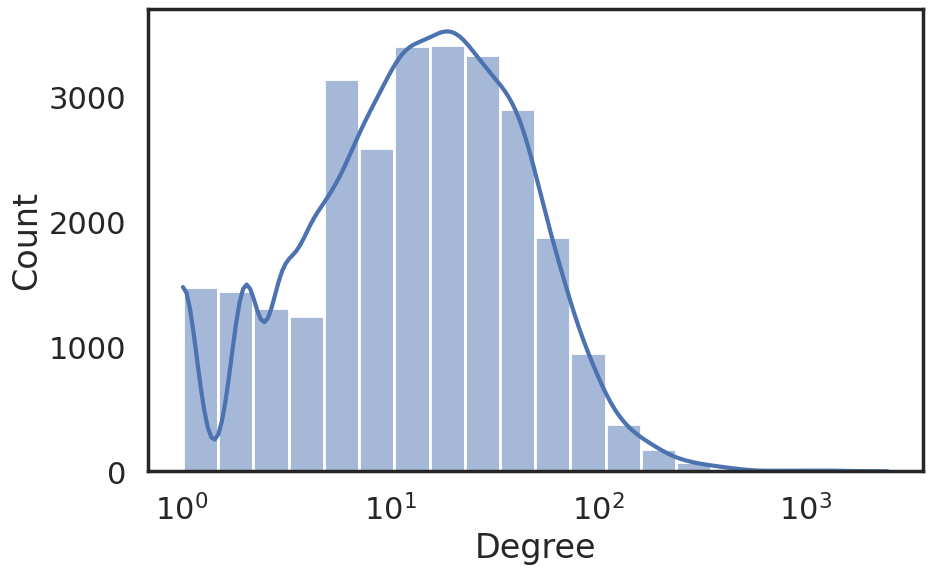

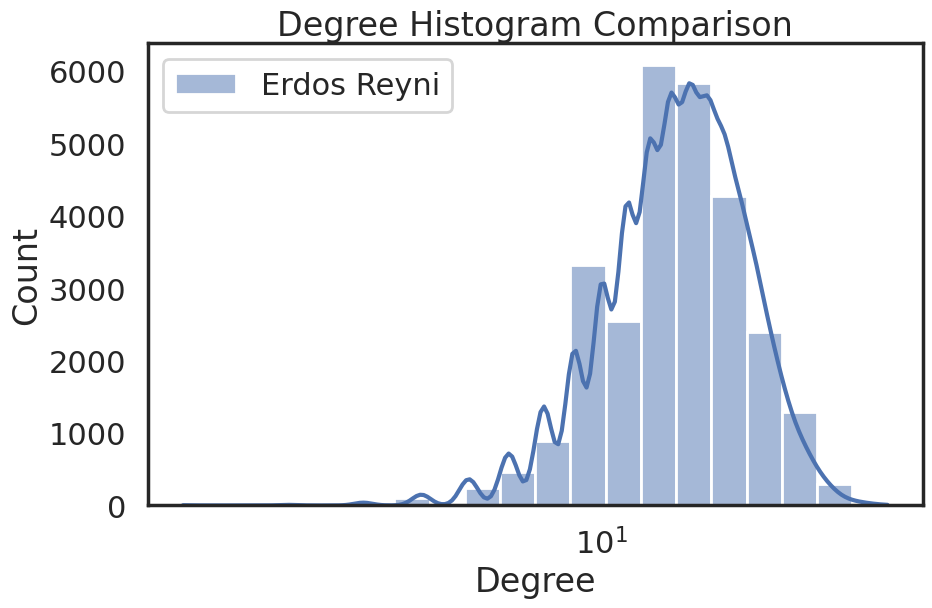

In [52]:
# Compare our graph with a random graph model
plot_degrees(G, G_er, compare_label="Erdos Reyni")

While narrower, this isn't completely dissimilar... and yet citation graphs are not known to look like random graph models. Let's check another. The [networkX Graph Generators documentation](https://networkx.org/documentation/stable/reference/generators.html) has a long list.

### Barabasi-Albert Model

Barabási-Albert Model (Preferential Attachment Model, Scale Free Network): This model generates a random graph where nodes are added to the network one at a time, and each new node attaches to existing nodes with a probability proportional to their degree.

A scale free network is one where its degree distribution fits a power law. In log scale, they proceed from top-left to bottom-right. Barabasi-Albert networks model step-wise growth of networks where edges are added in a way that prefers nodes with a higher degree.

<center><img alt="Random network vs a Scale Free network" src="images/random-vs-scale-free-network.jpg" /></center>

--Network-based approaches for anticancer therapy (Review), Seo et al, 2013.

In [53]:
# Number of iterations required (This should be smaller than the total number of nodes)
n = G.number_of_nodes()

# Number of edges to attach from a new node to existing nodes
m = G.number_of_edges() // n

print(f"n: {n:,} m: {m:,}")

# Create a Barabasi-Albert graph with the same number of nodes and edges as the real graph
G_ba = nx.barabasi_albert_graph(n, m)

n: 27,770 m: 12


In [54]:
print(f"Total nodes: {G_ba.number_of_nodes():,}")

Total nodes: 27,770


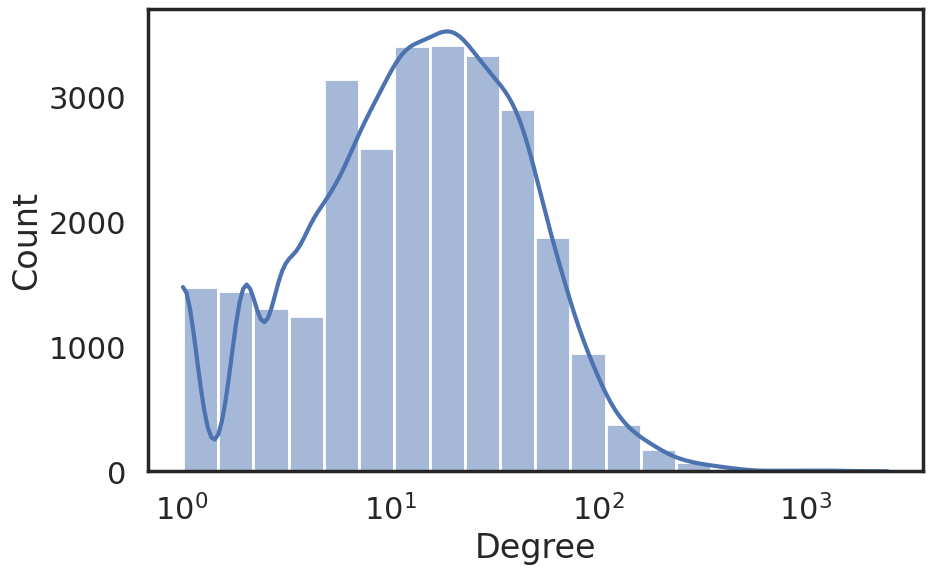

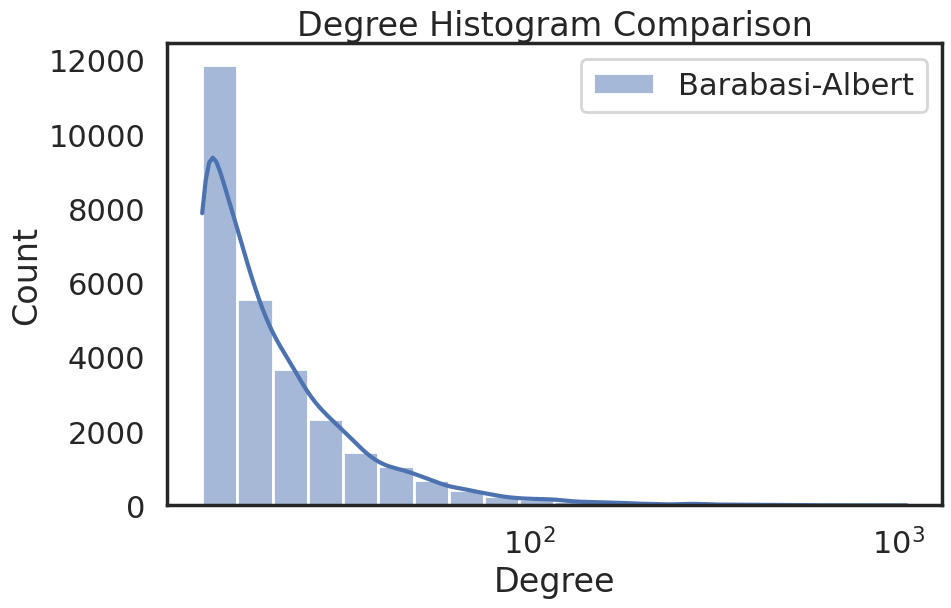

In [55]:
plot_degrees(G, G_ba, compare_label="Barabasi-Albert")

### Price's Citation Graph Random Model

Neither one of these fits the citation network very well. Some searching in the network science literature brings up this: Citation Graph Model. Wikipedia describes the first such model, Price's model as:

Price's model (named after the physicist Derek J. de Solla Price) is a mathematical model for the growth of citation networks.[1][2] It was the first model which generalized the Simon model[3] to be used for networks, especially for growing networks. Price's model belongs to the broader class of network growing models (together with the Barabási–Albert model) whose primary target is to explain the origination of networks with strongly skewed degree distributions. The model picked up the ideas of the Simon model reflecting the concept of rich get richer, also known as the Matthew effect. Price took the example of a network of citations between scientific papers and expressed its properties. His idea was that the way an old vertex (existing paper) gets new edges (new citations) should be proportional to the number of existing edges (existing citations) the vertex already has. This was referred to as cumulative advantage, now also known as preferential attachment. Price's work is also significant in providing the first known example of a scale-free network (although this term was introduced later). His ideas were used to describe many real-world networks such as the Web.

In [56]:
def citation_graph(n, m):
    """
    Create a citation graph with n nodes. Each new node attaches to m existing nodes.
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(2 * m))  # Start with 2m nodes
    G.add_edges_from((i, 2 * m) for i in range(2 * m))  # Each of the first 2m nodes links to the node 2m

    for i in range(2 * m + 1, n):
        # A new paper cites m existing papers. The probability of citing an existing paper is proportional to its in-degree.
        nodes = list(G.nodes())
        probabilities = [G.in_degree(n) for n in nodes]
        cited_nodes = random.choices(nodes, probabilities, k=m)
        for node in cited_nodes:
            G.add_edge(node, i)

    return G

In [57]:
# # Must run on sample... slow
# n = G.number_of_nodes()
# m = (G.number_of_edges() // n)  # integer division

# # Note: this can take a while
# G_cite = citation_graph(n, m)

# plot_degrees(G, G_cite, "Price's Model")

### Random Graph Model Lessons

We didn't fine the perfect random graph model using random graphs, but I hope these help you understand how to research what models might characterize your graph and what that means about it. As a data scientist, this is a valuable tool as it gives you the context you neex to make inferences about patterns in the network that can result in insight and clues for effective automation via machine learning. We could take this further and tune the parameters in Price's model or look for more citation network models that might fit better.

## Configuration Models

We've tried generating random graph models - even those with fitted parameters - to our network. None of them fit. We can make one that definitely will fit the degree distribution because that is how it is generated - the [Configuration Model](https://en.wikipedia.org/wiki/Configuration_model#:~:text=In%20network%20science%2C%20the%20configuration,to%20incorporate%20arbitrary%20degree%20distributions.).

<center><img src="images/degree_sequence_and_different_realizations_in_the_configuration_model.jpg" width="600px" /></center>
<p>Figure 1. Degree sequence and different network realizations in the configuration model[1], Wikipedia, <a href="https://en.wikipedia.org/wiki/Configuration_model#:~:text=In%20network%20science%2C%20the%20configuration,to%20incorporate%20arbitrary%20degree%20distributions.">Configuration Model</a></p>

We can use a configuration model or one of its more powerful extensions to generate random graphs that match the degree sequence - the degree histogram - of our network. This is a powerful technique as these networks can serve as a [random graph null model](https://en.wikipedia.org/wiki/Null_model).

Random Graph 0

Number of nodes: 30
Number of edges: 85
Mean degree: 5.667
Mediam degree: 6.000
Number of connected components: 2
Size of the largest component: 29
Mean clustering coefficient: 0.240397
Median clustering coefficient: 0.200000



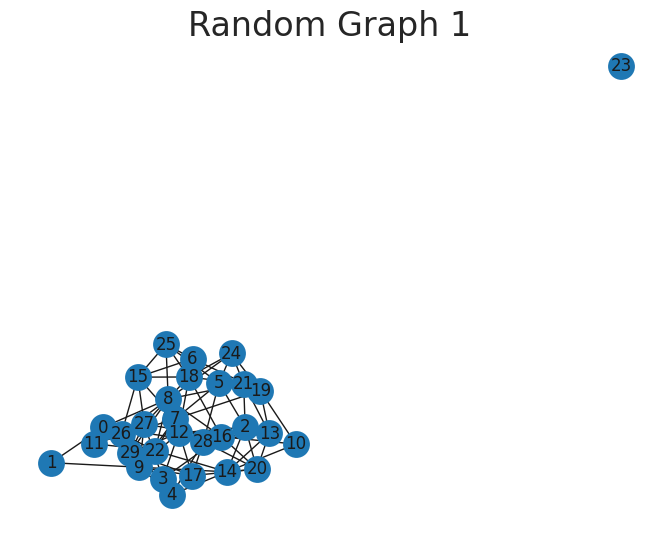

Random Graph 1

Number of nodes: 30
Number of edges: 84
Mean degree: 5.600
Mediam degree: 6.000
Number of connected components: 2
Size of the largest component: 29
Mean clustering coefficient: 0.219603
Median clustering coefficient: 0.200000



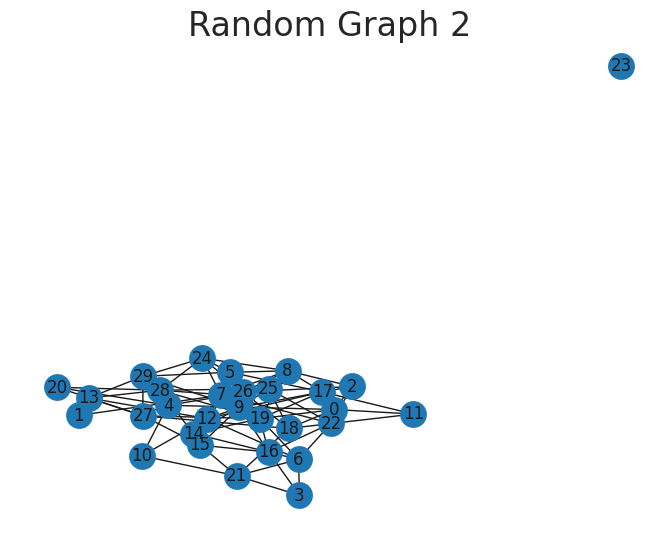

Random Graph 2

Number of nodes: 30
Number of edges: 78
Mean degree: 5.200
Mediam degree: 5.000
Number of connected components: 2
Size of the largest component: 29
Mean clustering coefficient: 0.215291
Median clustering coefficient: 0.219048



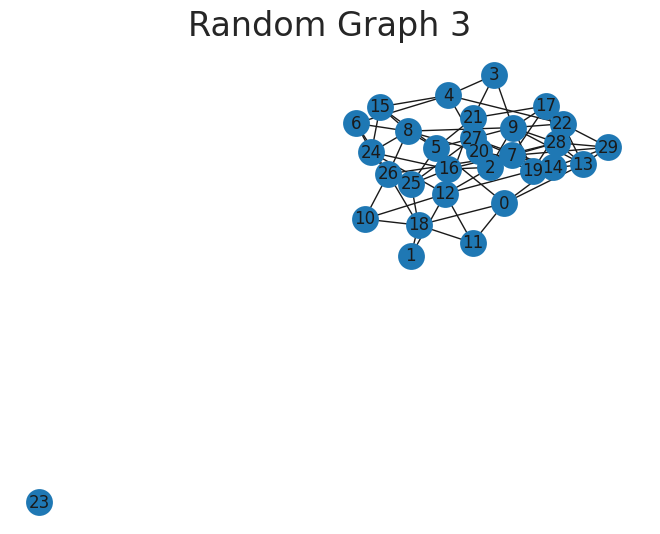

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming that G is your existing graph
G_rand = nx.erdos_renyi_graph(30, 0.2)

# Get the degree sequence of G
degree_sequence = [d for n, d in G_rand.degree()]

# Generate and draw 3 random graphs with the same degree sequence
for i in range(3):
    # Create a random graph from the degree sequence
    H = nx.configuration_model(degree_sequence)

    # In case of self-loops or parallel edges, 
    # we might want to create a simple graph with no self-loops or parallel edges.
    H = nx.Graph(H)
    H.remove_edges_from(nx.selfloop_edges(H))
    
    print(f"Random Graph {i}\n")
    describe_graph(H)
    print()
    
    plt.figure()
    nx.draw(H, with_labels=True)
    plt.title(f'Random Graph {i+1}')
    plt.show()

### Fitting Configuration Models to our Network

Let's try a variety of configuration models of different types and see how their properties compare to our citation network.

In [59]:
# H = nx.Graph(nx.configuration_model([d for n, d in G.degree()]))
# H = nx.watts_strogatz_graph(G.number_of_nodes(), 14, 0.40)

print("Original graph G:")
describe_graph(G)

print("\nWatts Strogatz model H:")
# print("\nConfiguration model H:")
describe_graph(H)

Original graph G:
Number of nodes: 27,770
Number of edges: 352,807
Mean degree: 25.409
Mediam degree: 14.000
Number of connected components: 143
Size of the largest component: 27,400
Number of strongly connected components: 20,086
Number of weakly connected components: 143
Mean clustering coefficient: 0.156925
Median clustering coefficient: 0.143275

Watts Strogatz model H:
Number of nodes: 30
Number of edges: 78
Mean degree: 5.200
Mediam degree: 5.000
Number of connected components: 2
Size of the largest component: 29
Mean clustering coefficient: 0.215291
Median clustering coefficient: 0.219048


In [60]:
g = (
    graphistry.bind(
        source="src",
        destination="dst",
        node="nodeid",
    )
    .scene_settings(
        edge_opacity=0.4,
        point_size=0.1,
    )
    .addStyle(
        page={
            "title": "Watts Strogatz Network",
            "favicon": FAVICON_URL
        },
        logo=LOGO,
    )
    .settings(
        url_params=GRAPHISTRY_PARAMS,
        height=800,
    )
)
g.plot(H)

<center><img src="images/Graphistry_Figure_3.png" /></center>

### Moving On...

You can see this still doesn't quite fit our model. We're going to examine a few of these networks using Grapistry to see how they differ.

## Centrality Metrics

Question: What are the most important papers in the field of physics during this period, from 1992 to 2003?
Metrics: Network centralities - metrics designed to determine the prominence of a node in its local neighborhood or the whole network.

You can find a number of centrality metrics under the [documentation for centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) in networkx.

We are going to compute several centralities and add them to our `networkx.DiGraph` as properties. Then we can visualize them to understand what they mean.

### Local Centralities

- Degree Centrality: the number of connections a node has. Variants: in-degree centrality and out-degree centrality, which count the number of in-bound and out-bound connections.

In [61]:
relative_degrees = nx.degree_centrality(G)

for node, relative_degree in relative_degrees.items():
    G.nodes[node]["relative_degree"] = relative_degree
    G.nodes[node]["relative_degree_log10"] = np.log10(relative_degree)

In [62]:
G.nodes[3]

{'file_id': 9309097,
 'sequential_id': 3,
 'Paper': 'hep-th/9309097',
 'Date': 'Fri, 17 Sep 93 17:18:41 EDT',
 'Title': 'Calabi-Yau Moduli Space, Mirror Manifolds and Spacetime Topology Change',
 'Authors': 'P.S. Aspinwall, B.R. Greene and D.R. Morrison',
 'Comments': '74 pages (with 20 figures)',
 'Report-no': 'IASSNS-HEP-93/38, CNLS-93/1236',
 'Journal-ref': 'Nucl.Phys. B416 (1994) 414-480',
 'Abstract': 'We analyze the moduli spaces of Calabi-Yau threefolds and their associated conformally invariant nonlinear sigma-models and show that they are described by an unexpectedly rich geometrical structure. Specifically, the Kahler sector of the moduli space of such Calabi-Yau conformal theories admits a decomposition into adjacent domains some of which correspond to the (complexified) Kahler cones of topologically distinct manifolds. These domains are separated by walls corresponding to singular Calabi-Yau spaces in which the spacetime metric has degenerated in certain regions. We show th

### Global Centralities

- Eigenvector Centrality
- Closeness Centrality
- Betweenness Centrality

#### So Many Centralities

Check out the networkx [Centrality Algorithms documentation](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) for a long list of other centralities. For a (not comprehnsive review) check out [Centrality Measures in Complex Networks: A Survey](https://arxiv.org/abs/2011.07190). I used to collect centrality algorithms, and had close to fifty in my list (sorry, now lost).

#### Eigenvector Centrality

This is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

In [63]:
# Eigenvector centrality is problematic in disconnected graphs, so take the largest component...
components = nx.connected_components(G.to_undirected())
largest_component = max(components, key=len)
G_big_component = G.subgraph(largest_component).copy()

print(f"Largest comonent size: {len(G_big_component):,}")

Largest comonent size: 27,400


In [64]:
# ... and make it undirected, to ensure it is connected
eigenvectors = nx.eigenvector_centrality_numpy(
    G_big_component.to_undirected()
)

for node, score in eigenvectors.items():
    G_big_component.nodes[node]["eigenvector"] = score
    G_big_component.nodes[node]["eigenvector_log10"] = np.log10(score + 0.000001)  # can't be zero for log

In [65]:
# Initialize eigenvector_centrality property as 0 for all nodes
nx.set_node_attributes(G, 0.0, "eigenvector")
nx.set_node_attributes(G, 0.0, "eigenvector_log10")

# Assign the eigenvector centrality values from subgraph to original graph
nx.set_node_attributes(G, {node: eigenvectors[node] for node in G_big_component}, "eigenvector")
nx.set_node_attributes(G, {node: np.log10(G.nodes[node]['eigenvector'] + 1e-10) for node in G.nodes()}, "eigenvector_log10")

In [66]:
G.nodes[3]

{'file_id': 9309097,
 'sequential_id': 3,
 'Paper': 'hep-th/9309097',
 'Date': 'Fri, 17 Sep 93 17:18:41 EDT',
 'Title': 'Calabi-Yau Moduli Space, Mirror Manifolds and Spacetime Topology Change',
 'Authors': 'P.S. Aspinwall, B.R. Greene and D.R. Morrison',
 'Comments': '74 pages (with 20 figures)',
 'Report-no': 'IASSNS-HEP-93/38, CNLS-93/1236',
 'Journal-ref': 'Nucl.Phys. B416 (1994) 414-480',
 'Abstract': 'We analyze the moduli spaces of Calabi-Yau threefolds and their associated conformally invariant nonlinear sigma-models and show that they are described by an unexpectedly rich geometrical structure. Specifically, the Kahler sector of the moduli space of such Calabi-Yau conformal theories admits a decomposition into adjacent domains some of which correspond to the (complexified) Kahler cones of topologically distinct manifolds. These domains are separated by walls corresponding to singular Calabi-Yau spaces in which the spacetime metric has degenerated in certain regions. We show th

#### Closeness Centrality

This measure calculates the average length of the shortest paths from a node to all other nodes in the network. Nodes with lower average shortest path lengths have higher closeness centrality and are often considered as being more central. A common interpretation of closeness centrality is that nodes with a high score are more likely to recieve information from other sources in the network than nodes with a low score.

Be aware that closeness and betweenness centrality are expensive to compute. They may not be available on large networks, or very densely connected networks. You can use NVIDIA RAPIDS [cuGraph centrality methods] if you have an NVIDIA GPU. Most data science work on GPUs is done on NVIDIA compatible GPUs.

In [67]:
# If this takes too long, be sure and run the above cell that substitutes G for G_
closeness = nx.closeness_centrality(G)

for node, score in closeness.items():
    G.nodes[node]["closeness"] = score
    G.nodes[node]["closeness_log10"] = np.log10(score + 1e-10)  # Add small epsilon to all values

In [68]:
G.nodes[3]

{'file_id': 9309097,
 'sequential_id': 3,
 'Paper': 'hep-th/9309097',
 'Date': 'Fri, 17 Sep 93 17:18:41 EDT',
 'Title': 'Calabi-Yau Moduli Space, Mirror Manifolds and Spacetime Topology Change',
 'Authors': 'P.S. Aspinwall, B.R. Greene and D.R. Morrison',
 'Comments': '74 pages (with 20 figures)',
 'Report-no': 'IASSNS-HEP-93/38, CNLS-93/1236',
 'Journal-ref': 'Nucl.Phys. B416 (1994) 414-480',
 'Abstract': 'We analyze the moduli spaces of Calabi-Yau threefolds and their associated conformally invariant nonlinear sigma-models and show that they are described by an unexpectedly rich geometrical structure. Specifically, the Kahler sector of the moduli space of such Calabi-Yau conformal theories admits a decomposition into adjacent domains some of which correspond to the (complexified) Kahler cones of topologically distinct manifolds. These domains are separated by walls corresponding to singular Calabi-Yau spaces in which the spacetime metric has degenerated in certain regions. We show th

#### Betweenness Centrality

This measure considers a node's position within the network in terms of the paths between other nodes. Nodes that frequently lie on the shortest paths between other nodes in the network have a high betweenness centrality. These nodes serve as important points of control and coordination within the network.

Betweenness centrality is so expensive it quickly becomes infeasible on large networks. GPUs can extend this capability in libraries like [NVIDIA RAPIDS cuGraph's](https://github.com/rapidsai/cugraph) [cugraph.betweenness_centrality](https://docs.rapids.ai/api/cugraph/legacy/api_docs/api/cugraph.betweenness_centrality.html) feature.

A course with NVIDIA support and cuGraph is available. Please <a href="mailo:rjurney@graphlet.ai" style="color: blue">contact me at rjurney@graphlet.ai</a> if you'd like a private class covering cuGraph or other, related topics we don't explore.

In [69]:
# # Note: this is too slow to actually run on CPU! We need to use cuGraph on a GPU.
# between = nx.betweenness_centrality(G)
# # nx.set_node_attribute(G, between)

# for node, score in between.items():
#     G.nodes[node]["betweenness"] = score

In [70]:
G.nodes[3]

{'file_id': 9309097,
 'sequential_id': 3,
 'Paper': 'hep-th/9309097',
 'Date': 'Fri, 17 Sep 93 17:18:41 EDT',
 'Title': 'Calabi-Yau Moduli Space, Mirror Manifolds and Spacetime Topology Change',
 'Authors': 'P.S. Aspinwall, B.R. Greene and D.R. Morrison',
 'Comments': '74 pages (with 20 figures)',
 'Report-no': 'IASSNS-HEP-93/38, CNLS-93/1236',
 'Journal-ref': 'Nucl.Phys. B416 (1994) 414-480',
 'Abstract': 'We analyze the moduli spaces of Calabi-Yau threefolds and their associated conformally invariant nonlinear sigma-models and show that they are described by an unexpectedly rich geometrical structure. Specifically, the Kahler sector of the moduli space of such Calabi-Yau conformal theories admits a decomposition into adjacent domains some of which correspond to the (complexified) Kahler cones of topologically distinct manifolds. These domains are separated by walls corresponding to singular Calabi-Yau spaces in which the spacetime metric has degenerated in certain regions. We show th

#### Betweenness Centrality in `networkit`

While we can't use a GPU in this course with [`cugraph.centrality.betweenness_centrality`](https://docs.rapids.ai/api/cugraph/stable/api_docs/api/cugraph/cugraph.centrality.betweenness_centrality/) for technical reasons (you may not have an NVIDIA GPU), we can use [NetworKit](https://networkit.github.io/) to take advantage of multiple processor cores.

NetworKit uses multiple CPU cores, check out 15 of them on my new Maxbook Pro :)

<center><img src="images/NetworKit Compute Top.png" /></center>

In [103]:
from networkit.centrality import ApproxBetweenness, Closeness
from networkit.nxadapter import nx2nk


btwn = ApproxBetweenness(nx2nk(G))
btwn.run()
btwn_scores = btwn.scores()

In [104]:
closeness = Closeness(nx2nk(G), True, True)
closeness.run()
closeness_scores = closeness.scores()

### Visualizing Metrics in Graphistry

Let's zoom in on one section of the network to make it manageable and then look at just those nodes. Nodes are sized by degree by default in Graphistry. Let's click on one of the largest nodes and perform a snowball sample two hops out.

In [73]:
g = (
    graphistry.bind(
        source="src",
        destination="dst",
        node="nodeid",
        point_title="Title",
        point_label="Title",
    )
    .scene_settings(
        edge_opacity=0.4,
    )
    .addStyle(
        page={
            "title": "Simple Plot",
            "favicon": FAVICON_URL
        },
        logo=LOGO
    )
    .settings(
        url_params=GRAPHISTRY_PARAMS,
        height=800
    )
)
g.plot(G)

#### Closeness vs Betweenness

<center><img src="images/Graphistry_Figure_4.png" /></center>

#### Degree vs Clustering Coefficient

<center>
    <img src="images/Graphistry_Comparison_Viz.png" />
</center>

### Try other Centralities

Now try additional centrality pairs like degree vs PageRank to see how they look!

## More on Sampling Networks

> Large-scale networks, seen in contexts like social media or bioinformatics, bring forth considerable computational challenges due to their size and complexity. Traditional algorithms and infrastructures often struggle to efficiently compute global network measures, visualize data, and manage inherent noise in these large datasets. Network sampling, which involves selecting a representative subset of the network, offers a way to alleviate these issues. It enables feasible computation and interpretation of network properties. However, creating effective sampling strategies is crucial to maintain the original network's key characteristics, ensuring accurate inferences about the larger system.

There are three major types of sampling a network: random sampling, snowball sampling and random walk sampling.

- Random sampling selects random nodes from the network and includes edges between those nodes that are in the sample. This makes sense when your graph fits a random graph model like Erdos Reyni.
- Snowball sampling creates an "ego network" which is centered on a single node of particular interest. It is useful when you want to investigate a region of a network. An ego (a node) may be of particular interest in the context of its alters (its neighbors) or a cluster or region of the graph may require your attention. Snowball sampling can "zoom in" to assist with visualization, which we will use below.

## Snowball Sampling

> In the context of network science, a snowball sample is a method of data collection that uses a cascading or "snowball" effect to discover and analyze nodes in a network. It's often used when you don't have access to the entire network data, or when the network is too large to feasibly analyze in its entirety.
>
> The process begins with a small set of "seed" nodes in the network. You identify all nodes that these seed nodes are directly connected to (i.e., their neighbors), and add them to your sample. This is often referred to as one "hop" or "wave" out from the seed nodes.
>
> But the process doesn't stop there, much like a snowball rolling down a hill and growing in size, you continue the process for these newly added nodes, finding all of their connected nodes, or neighbors, and adding them to your sample. This is the second hop, and you can continue this for as many "hops" as you want, each time expanding the number of nodes in your sample.
>
> When we say "1.5 hop" in the context of a snowball sampling of a network, it typically means that we start from a certain node (or set of nodes), then we include all the direct neighbors of this node (that's the first "hop"), and then for the "0.5" hop, we also include nodes that are connected to the nodes in the first hop but not include their connections (i.e., not going another full hop further). The idea behind this is to gather a slightly wider view of the network around our starting point, but without expanding to the full 2-hop neighborhood, which could significantly increase the size of the sample.

--I am *pretty sure* I wrote this, with ChatGPT, a year ago...

In [74]:
def snowball_sample(graph, start_nodes, hops: int):
    """
    Perform an n-hop snowball sample on the given graph.
    
    :param graph: The NetworkX graph.
    :param start_nodes: The nodes to start the snowball sampling from.
    :param n: The number of hops. Connections within the nodes are automatically included.
    :return: A subgraph of the given graph that is the result of the n-hop snowball sampling.
    """
    # First add all start_nodes to the sample (0 hops)
    sampled_graph = graph.subgraph(start_nodes).copy()

    # Then add all their neighbors (1 hop)
    for i in range(0, n):
        for node in start_nodes:
            sampled_graph.add_nodes_from(graph.neighbors(node))
            sampled_graph.add_edges_from((node, neighbor) for neighbor in graph.neighbors(node))

    # Finally, add edges between the neighbors (.5 hops, as in a 1.5 hop snowball sample)
    # We iterate over all nodes in the sampled graph and, for each, add edges to its neighbors that are also in the sampled graph
    for node in list(sampled_graph.nodes):
        neighbors = set(graph.neighbors(node))
        sampled_neighbors = neighbors.intersection(set(sampled_graph.nodes))
        sampled_graph.add_edges_from((node, sampled_neighbor) for sampled_neighbor in sampled_neighbors)

    return sampled_graph

## Snowball Sampling an Influential Paper

The 1997 paper [M Theory As A Matrix Model: A Conjecture, Banks et al, 1997](https://arxiv.org/abs/hep-th/9610043) has a degree of 1,219. It is a highly influential paper and has now received 2,710. Let's start with it and do a snowball sample.

In [75]:
G_orig.nodes[file_to_net[9610043]], file_to_net[9610043]

({'file_id': 9610043,
  'sequential_id': 469,
  'Paper': 'hep-th/9610043',
  'From': 'Stephen Shenker',
  'Date': 'Mon, 7 Oct 1996 17:32:58 -0400',
  'Title': 'M Theory As A Matrix Model: A Conjecture',
  'Authors': 'T. Banks, W. Fischler, S.H. Shenker, L. Susskind',
  'Comments': 'Typo and tex error corrected. 41 pages, harvmac',
  'Report-no': 'RU-96-95, SU-ITP-96-12,UTTG-13-96',
  'Journal-ref': 'Phys.Rev. D55 (1997) 5112-5128',
  'Abstract': 'We suggest and motivate a precise equivalence between uncompactified eleven dimensional M-theory and the N = infinity limit of the supersymmetric matrix quantum mechanics describing D0-branes. The evidence for the conjecture consists of several correspondences between the two theories. As a consequence of supersymmetry the simple matrix model is rich enough to describe the properties of the entire Fock space of massless well separated particles of the supergravity theory. In one particular kinematic situation the leading large distance interac

In [76]:
# Run a snowball sample in the largest component so we get a good sample
components = [c for c in nx.weakly_connected_components(G)]
component_index_sizes = [(i, len(c)) for i, c in enumerate(components)]
biggest_component_index, max_size = max(component_index_sizes, key=lambda x: x[1])
biggest_component_index, max_size

(0, 27400)

In [77]:
big_component_nodes = components[biggest_component_index]

In [78]:
G_big_component = G.subgraph(big_component_nodes)
G_big_component.number_of_nodes(), G_big_component.number_of_edges()

(27400, 352542)

In [79]:
# # Take a random snowball sample until we get one with a good amount of nodes, 100-1000
# center_nodes = [np.random.choice(list(big_component_nodes)) for x in range(0,100)]

# G_snowball = snowball_sample(G_big_component, center_nodes, 3)
# G_snowball.number_of_nodes(), G_snowball.number_of_edges()

In [80]:
from littleballoffur import SnowBallSampler


snowball_sampler = SnowBallSampler(1000, 2)
G_snowball = snowball_sampler.sample(G.to_undirected(), 469)
G_snowball.number_of_nodes(), G_snowball.number_of_edges()

(1000, 7402)

We are going to load the snowball sample of `M Theory As A Matrix Model: A Conjecture` we created and investigate what the metrics we previously computed mean.

In [81]:
g = (
    graphistry.bind(
        source="src",
        destination="dst",
        node="nodeid",
        point_title="Title",
        point_label="Title",
    )
    .scene_settings(
        edge_opacity=0.4,
    )
    .addStyle(
        page={
            "title": "Simple Plot",
            "favicon": FAVICON_URL
        },
        logo=LOGO
    )
    .settings(
        url_params=GRAPHISTRY_PARAMS,
        height=800,
    )
)
g.plot(G_snowball)

<center><img src="images/Graphistry_Figure_7.png" /></center>

# Beware of Supernodes!

Network algorithms can be difficult to scale because comparing every node to every other node has n^2 complexity.

<br /><center><img src="images/github_adjacency_rjurney.webp" width="600px" /></center><br />

Supernodes are a DEAL STOPPER. What? To rephrase: a common obstacle in implmenting graph algorithms, using common tools or even simple graph processing is when on node has LOTS of connections and processing all of them would take until the end of time.

## Addressing Supernodes

You can usually efficiently compute the degree of the edges... it is just a `GROUP BY` / `MapReduce` of the node ID at either end followed by a `COUNT(*)`. This gives you in and out degree in a directional network - add them together to get total degree. As we did above, plot a histogram of node degrees. Inspect some of the nodes with the highest degree. Use the histogram to decide on a good cutoff point to filter the node out completely... if you can. Otherwise think about removing edges from that node that aren't important.

In [82]:
print(f"Degree: {len(nx.degree(G))}, Degree^2: {len(nx.degree(G)) * len(nx.degree(G)):,}")

Degree: 27770, Degree^2: 771,172,900


# Sophisticated Sampling with `littleballoffur`

<br />

<center><img src="images/littleballoffur_logo_text.jpg" width="700px" /></center>

<br /><br />

The [littleballoffur](https://little-ball-of-fur.readthedocs.io/en/latest/notes/introduction.html) library has many sampling methods for both nodes and edges.

Types of sampling include:

## Node Sampling Methods

* [RandomNodeSampler](https://little-ball-of-fur.readthedocs.io/en/latest/modules/node_sampling.html#littleballoffur.node_sampling.randomnodesampler.RandomNodeSampler)
* [DegreeBasedSampler](https://little-ball-of-fur.readthedocs.io/en/latest/modules/node_sampling.html#littleballoffur.node_sampling.degreebasedsampler.DegreeBasedSampler)
* [PageRankBasedSampler](https://little-ball-of-fur.readthedocs.io/en/latest/modules/node_sampling.html#littleballoffur.node_sampling.pagerankbasedsampler.PageRankBasedSampler)

## Edge Sampling Methods

* [RandomEdgeSampler](https://little-ball-of-fur.readthedocs.io/en/latest/modules/edge_sampling.html#littleballoffur.edge_sampling.randomedgesampler.RandomEdgeSampler)
* [RandomNodeEdgeSampler](https://little-ball-of-fur.readthedocs.io/en/latest/modules/edge_sampling.html#littleballoffur.edge_sampling.randomnodeedgesampler.RandomNodeEdgeSampler)
* [HybridNodeEdgeSampler](https://little-ball-of-fur.readthedocs.io/en/latest/modules/edge_sampling.html#littleballoffur.edge_sampling.hybridnodeedgesampler.HybridNodeEdgeSampler)
* [RandomEdgeSamplerWithPartialInduction](https://little-ball-of-fur.readthedocs.io/en/latest/modules/edge_sampling.html#littleballoffur.edge_sampling.randomedgesamplerwithpartialinduction.RandomEdgeSamplerWithPartialInduction)
* [RandomEdgeSamplerWithInduction](https://little-ball-of-fur.readthedocs.io/en/latest/modules/edge_sampling.html#littleballoffur.edge_sampling.randomedgesamplerwithinduction.RandomEdgeSamplerWithInduction)

## Exploration Sampling

> The common idea in this family of sampling techniques is that we first select a node uniformly at random and then explore the nodes in its the vicinity.
>
> --Sampling from Large Graphs, Leskovec, J; Faloutsos, C; 2006.

* [DiffusionSampler](https://little-ball-of-fur.readthedocs.io/en/latest/modules/exploration_sampling.html#littleballoffur.exploration_sampling.diffusionsampler.DiffusionSampler)
* ... too many to list :) [ChatGPT-4 dies when I ask it to do the information extraction]

## Exercise: Sample `G_orig` and Visualize in Graphistry

Try different sampling methods using `littleballoffur`. How do they affect the structre you see in Graphistry? What about the charts above? Visualize the graph returned by different parameters of our `G_orig` network. Try taking a new `G_my_sample` sampled network and replacing the `G` variable up top where we created the `G_orig` variabl the first time we did so.

What changed? Can you tell? Try making all nodes the same size to focus on the topology and structre of the network. Ask for help if you need it!

**NOTE: REMEMBER TO USE THE `G_orig` VARIABLE NOT `G` if you replaced it above.**

In [83]:
# This is a better [more reliable, has unit tests] way to go than my own implementation above...
from littleballoffur import PageRankBasedSampler, NonBackTrackingRandomWalkSampler, RandomWalkSampler, ForestFireSampler, RandomEdgeSampler


sample_node_size = 10000
sampler = PageRankBasedSampler(sample_node_size)

# Most of these use undirected graphs
G_new = sampler.sample(G_orig.to_undirected())
G_new.number_of_nodes(), G_new.number_of_edges()

(10000, 103552)

In [84]:
print(f"Original graph:\n")
describe_graph(G_orig)

Original graph:

Number of nodes: 27,770
Number of edges: 352,807
Mean degree: 25.409
Mediam degree: 14.000
Number of connected components: 143
Size of the largest component: 27,400
Number of strongly connected components: 20,086
Number of weakly connected components: 143
Mean clustering coefficient: 0.156925
Median clustering coefficient: 0.143275


In [85]:
print(f"Sampled graph:\n")
describe_graph(G_new)

Sampled graph:

Number of nodes: 10,000
Number of edges: 103,552
Mean degree: 20.710
Mediam degree: 12.000
Number of connected components: 430
Size of the largest component: 9,445
Mean clustering coefficient: 0.312153
Median clustering coefficient: 0.291148


In [86]:
print(f"Snowball sampled graph:\n")
describe_graph(G_snowball)

Snowball sampled graph:

Number of nodes: 1,000
Number of edges: 7,402
Mean degree: 14.804
Mediam degree: 10.000
Number of connected components: 1
Size of the largest component: 1,000
Mean clustering coefficient: 0.357947
Median clustering coefficient: 0.333333


In [87]:
# Our properties are still there... new_graph
list(G_new.nodes(data=True))[0]

(0,
 {'file_id': 1001,
  'sequential_id': 0,
  'Paper': 'hep-th/0001001',
  'From': 'Paul S. Aspinwall',
  'Date': 'Sat, 1 Jan 2000 00:02:31 GMT',
  'Title': 'Compactification, Geometry and Duality: N=2',
  'Authors': 'Paul S. Aspinwall',
  'Comments': '82 pages, 8 figures, LaTeX2e, TASI99, refs added and some typos fixed',
  'Report-no': 'DUKE-CGTP-00-01',
  'Published': 946684800,
  'Journal-ref-DBSCAN': 0,
  'Journal-ref-Label': '',
  'label': '0',
  'clustering_coefficient': 0.08391771856007481})

In [88]:
g = (
    graphistry.bind(
        source="src",
        destination="dst",
        node="nodeid",
        point_title="Title",
        point_label="Title",
    )
    .scene_settings(
        edge_opacity=0.4,
    )
    .addStyle(
        page={
            "title": "Simple Plot",
            "favicon": FAVICON_URL
        },
        logo=LOGO
    )
    .settings(
        url_params=GRAPHISTRY_PARAMS,
        height=800,
    )
)
g.plot(G_new)

<center><img src="images/Graphistry_Figure_6.png" /></center>